In [1]:
import mysql_auth 
from MySQLConnection import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from Modeling import *

In [2]:
# conn = MySQLConnection(DB_info=mysql_auth.NYXL_DB_Match_FinalStat)
# input_df = conn.read_all_tables_as_df()
# input_df.to_csv('input_df.csv')

In [3]:
input_df = pd.read_csv('input_df.csv')
display(input_df)

C:\Users\jyc13\anaconda3\envs\owl-data\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (6,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,MatchId,num_map,Map,map_type,Section,RoundName,Timestamp,Team,Player,...,OffensiveAssists/s,RCP,FBValue,DeathRisk,TF_order,TF_winner,TF_duration,TF_RCP_sum,TF_RCP_weighted_sum,DominanceIndex
0,0,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Doha,...,0.0,-1.750000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
1,1,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Fielder,...,0.0,-1.750000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
2,2,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Jecse,...,0.0,-1.750000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
3,3,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Houston Outlaws,Crimzo,...,0.0,-1.750000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
4,4,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Houston Outlaws,Happy,...,0.0,-1.750000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551233,4551233,37420,5,Nepal,CONTROL,3.0,Village,2021-07-17 05:34:52,Dallas Fuel,Jecse,...,1.0,1.833333,0.0,0.0,5.0,Dallas Fuel,14.118,1.833333,4.983517,0.337474
4551234,4551234,37420,5,Nepal,CONTROL,3.0,Village,2021-07-17 05:34:52,Dallas Fuel,Jecse,...,0.0,1.833333,0.0,0.0,5.0,Dallas Fuel,14.118,1.833333,4.983517,0.337474
4551235,4551235,37420,5,Nepal,CONTROL,3.0,Village,2021-07-17 05:34:52,Dallas Fuel,SP9RK1E,...,0.0,1.833333,0.0,0.0,5.0,Dallas Fuel,14.118,1.833333,4.983517,0.337474
4551236,4551236,37420,5,Nepal,CONTROL,3.0,Village,2021-07-17 05:34:52,Dallas Fuel,SP9RK1E,...,0.0,1.833333,0.0,0.0,5.0,Dallas Fuel,14.118,1.833333,4.983517,0.337474


In [4]:
input_df['position_x'] = input_df['position'].str.split(',').str[0].astype('float')
input_df['position_y'] = input_df['position'].str.split(',').str[2].astype('float')
input_df['position_z'] = input_df['position'].str.split(',').str[1].astype('float')

In [5]:
def get_distance_from_center(input_df):
    input_df[['position_x_norm', 'position_y_norm', 'position_z_norm']] = input_df.groupby(['MatchId', 'num_map', 'Section'])[['position_x', 'position_y', 'position_z']].apply(lambda x: (x - x.min()) / (x.max() - x.min()) )
    avg_position_x = input_df.groupby(['MatchId', 'num_map', 'Section', 'Timestamp', 'Team'])[['position_x_norm']].mean()
    avg_position_y = input_df.groupby(['MatchId', 'num_map', 'Section', 'Timestamp', 'Team'])[['position_y_norm']].mean()
    avg_position_z = input_df.groupby(['MatchId', 'num_map', 'Section', 'Timestamp', 'Team'])[['position_z_norm']].mean()

    input_df = input_df.set_index(['MatchId', 'num_map', 'Section', 'Timestamp', 'Team'])

    df_merge = pd.merge(input_df, avg_position_x, left_index=True, right_index=True, suffixes=('', '_avg'))
    df_merge = pd.merge(df_merge, avg_position_y, left_index=True, right_index=True, suffixes=('', '_avg'))
    df_merge = pd.merge(df_merge, avg_position_z, left_index=True, right_index=True, suffixes=('', '_avg'))

    df_merge.dropna(axis=0, how='any', inplace=True)
    df_merge['distance_from_center'] = ((df_merge['position_x_norm_avg'] - df_merge['position_x_norm'])**2 + (df_merge['position_y_norm_avg'] - df_merge['position_y_norm'])**2 + (df_merge['position_z_norm_avg'] - df_merge['position_z_norm'])**2)**(1/2)

    output_df = df_merge.reset_index()
    return output_df

In [6]:
input_df = get_distance_from_center(input_df)

In [7]:
from scipy.spatial import ConvexHull

def ConvHullArea(X):
    # X = X[X.loc[:,'IsAlive']==1]
    X = X[X['IsAlive']==1]
    points = X.iloc[:,1:3].values
    try:
        hull = ConvexHull(points)
        area = hull.area
    except: 
        area = 0
    return area

df_points = input_df.groupby(['MatchId', 'num_map', 'Map', 'Section', 'Timestamp', 'Team'])[['IsAlive', 'position_x', 'position_y']].apply(ConvHullArea)

df_points = df_points.reset_index()
df_points.rename(columns={0:'ConvHullArea'}, inplace=True)

df_merge = pd.merge(input_df, df_points, how='outer', on=['MatchId', 'num_map', 'Map', 'Section', 'Timestamp', 'Team'])

In [66]:
selected_features = [
    'FinalBlows/s', 'Deaths/s',
    'TimePlayed/s', 'HeroDamageDealt/s', 'BarrierDamageDealt/s', 
    'HeroDamageTaken/s', 'HealingDealt/s', 'HealingReceived/s', 
    'EnvironmentalDeaths/s', 'EnvironmentalKills/s', 'SoloKills/s', 
    'UltimatesUsed/s', 'distance_from_center', 'ConvHullArea'
]
# selected_features = [
#     'FBValue', 'DeathRisk',
#     'TimePlayed/s', 'HeroDamageDealt/s', 'BarrierDamageDealt/s', 
#     'HeroDamageTaken/s', 'HealingDealt/s', 'HealingReceived/s', 
#     'EnvironmentalDeaths/s', 'EnvironmentalKills/s', 'SoloKills/s', 
#     'UltimatesUsed/s', 'distance_from_center', 'ConvHullArea'
# ]

In [67]:
df_init = df_merge[df_merge['TF_order'].notna()]
df_init['IsTFWinner'] = df_init['Team'] == df_init['TF_winner'] # TF_winner
df_init['IsMapWinner'] = df_init['Team'] == df_init['MapWinner'] # Map_winner
target_flag = 'Teamfight' # Map or Teamfight

if target_flag == 'Map':
    grouping_index = ['MatchId', 'num_map', 'Map', 'Team']
    target = 'IsMapWinner'
elif target_flag == 'Teamfight':
    grouping_index = ['MatchId', 'num_map', 'Map', 'Section', 'TF_order', 'Team']
    target = 'IsTFWinner'

df_init['HeroComp'] = df_init['Hero']
df_init = pd.get_dummies(data=df_init, columns=['HeroComp'], prefix='Hero')
df_init = df_init[df_init['TimePlayed/s'] != 0]
df_X = df_init.groupby(grouping_index)[selected_features + [x for x in df_init.columns if x.startswith('Hero_')] + [target]].sum()
# df_X = df_init.groupby(grouping_index)[selected_features + [x for x in df_init.columns if x.startswith('Hero_')] + [target]].first()

df_X.replace({False:0, True:1}, inplace=True)
df_X.loc[df_X[target] != 0, target] = 1
hero_col = [x for x in df_X.columns if x.startswith('Hero_')]
for col in hero_col:
    df_X.loc[df_X[col] != 0, col] = 1

df_y = df_X[target]
df_X = df_X.drop(target, axis=1)
df_X = df_X.drop([x for x in df_X.columns if x.startswith('Hero_')], axis=1) # drop HeroComp

df_X_norm = df_X.groupby([x for x in grouping_index if x != 'Team']).apply(lambda x: x/x.sum()) # 팀 상대적으로 비교하기 위해 normalization
df_X_norm = df_X_norm.fillna(0)

display(df_X_norm)
display(df_y)

FinalBlows/s  Deaths/s  \
MatchId num_map Map           Team                                         
37147   1       Busan         Dallas Fuel             0.680000  0.339623   
                              Houston Outlaws         0.320000  0.660377   
37148   1       Oasis         Florida Mayhem          0.506024  0.494253   
                              Washington Justice      0.493976  0.505747   
37149   1       Busan         Dallas Fuel             0.687500  0.318182   
...                                                        ...       ...   
37419   1       Lijiang Tower Dallas Fuel             0.350365  0.635135   
37420   1       Lijiang Tower Atlanta Reign           0.291139  0.703704   
                              Dallas Fuel             0.708861  0.296296   
        5       Nepal         Atlanta Reign           0.464646  0.568627   
                              Dallas Fuel             0.535354  0.431373   

                                                  TimePlayed/s  \
MatchId num_map Map           Team                               
37147   1       Busan         Dallas Fuel             0.496505   
                              Houston Outlaws         0.503495   
37148   1       Oasis         Florida Mayhem          0.499771   
                              Washington Justice      0.500229   
37149   1       Busan         Dallas Fuel             0.501186   
...                                                        ...   
37419   1       Lijiang Tower Dallas Fuel             0.499924   
37420   1       Lijiang Tower Atlanta Reign           0.500000   
                              Dallas Fuel             0.500000   
        5       Nepal         Atlanta Reign           0.515651   
                              Dallas Fuel             0.484349   

                                                  HeroDamageDealt/s  \
MatchId num_map Map           Team                                    
37147   1       Busan         Dallas Fuel                  0.488465   
                              Houston Outlaws              0.511535   
37148   1       Oasis         Florida Mayhem               0.516661   
                              Washington Justice           0.483339   
37149   1       Busan         Dallas Fuel                  0.559374   
...                                                             ...   
37419   1       Lijiang Tower Dallas Fuel                  0.472625   
37420   1       Lijiang Tower Atlanta Reign                0.453535   
                              Dallas Fuel                  0.546465   
        5       Nepal         Atlanta Reign                0.505305   
                              Dallas Fuel                  0.494695   

                                                  BarrierDamageDealt/s  \
MatchId num_map Map           Team                                       
37147   1       Busan         Dallas Fuel                     0.576882   
                              Houston Outlaws                 0.423118   
37148   1       Oasis         Florida Mayhem                  0.555858   
                              Washington Justice              0.444142   
37149   1       Busan         Dallas Fuel                     0.451044   
...                                                                ...   
37419   1       Lijiang Tower Dallas Fuel                     0.088843   
37420   1       Lijiang Tower Atlanta Reign                   0.507493   
                              Dallas Fuel                     0.492507   
        5       Nepal         Atlanta Reign                   0.541760   
                              Dallas Fuel                     0.458240   

                                                  HeroDamageTaken/s  \
MatchId num_map Map           Team                                    
37147   1       Busan         Dallas Fuel                  0.502501   
                              Houston Outlaws              0.497499   
37148   1       Oasis         F

MatchId  num_map  Map            Team              
37147    1        Busan          Dallas Fuel           1
                                 Houston Outlaws       0
37148    1        Oasis          Florida Mayhem        1
                                 Washington Justice    0
37149    1        Busan          Dallas Fuel           1
                                                      ..
37419    1        Lijiang Tower  Dallas Fuel           0
37420    1        Lijiang Tower  Atlanta Reign         0
                                 Dallas Fuel           1
         5        Nepal          Atlanta Reign         0
                                 Dallas Fuel           1
Name: IsMapWinner, Length: 460, dtype: int64

In [68]:
X = df_X_norm.values
y = df_y.values
feature_names = df_X_norm.columns 
# scaler = RobustScaler()
# X = scaler.fit_transform(X)
print(X.shape, y.shape)

(460, 14) (460,)


In [69]:
dnn = ModelDNN(X=X, y=y) 
dnn.create_model()

X_train shape :  (308, 14)
y_train shape :  (308,)
X_test shape :  (152, 14)
y_test shape :  (152,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                960       
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 65        
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________


In [70]:
dnn.train_model(num_epoch=30000, batch_size=5000, patience=300, verbose=0)
dnn.model.evaluate(dnn.X_test, dnn.y_test, batch_size=3000, verbose=0)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 64)                960       
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)                

KeyboardInterrupt: 

## SHAP Interpretation

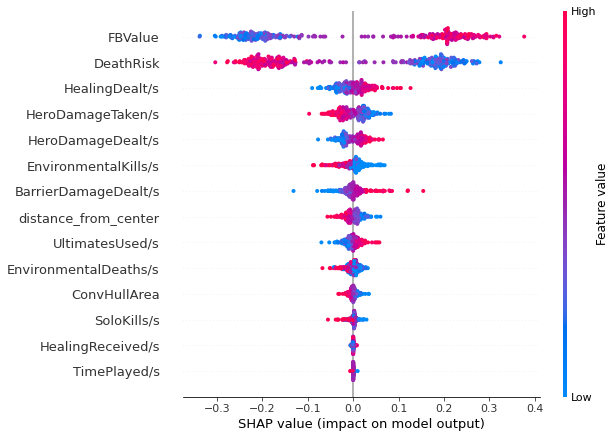

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model
explainer = shap.GradientExplainer(dnn.model, dnn.X_train)
shap_values = explainer.shap_values(dnn.X_train)

# plot
# shap.summary_plot(shap_values, dnn.X_test, feature_names=feature_names)
shap.summary_plot(shap_values[0], dnn.X_train, feature_names=feature_names)

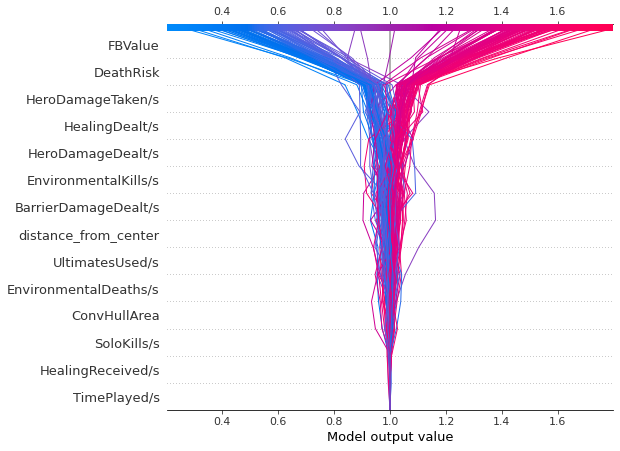

In [ ]:
y_hat = dnn.model.predict(dnn.X_train[:150])
shap.decision_plot(y_hat[0], shap_values[0][:150], feature_names)

## 개별 항목 SHAP Explaination

In [ ]:
df = df_X.reset_index()
df[(df['Team'] == 'New York Excelsior') & (df['MatchId']==37362)]

,MatchId,num_map,Map,Team,FBValue,DeathRisk,TimePlayed/s,HeroDamageDealt/s,BarrierDamageDealt/s,HeroDamageTaken/s,HealingDealt/s,HealingReceived/s,EnvironmentalDeaths/s,EnvironmentalKills/s,SoloKills/s,UltimatesUsed/s,distance_from_center,ConvHullArea
355,37362,1,Nepal,New York Excelsior,47.057143,36.5,2600.79951,32196.31707,318.1271,27637.354,12335.545,13149.068,0.0,0.0,6.0,22.0,168.490422,133489.480451


In [ ]:
i = 844
if i % 2 == 0: 
    j = i + 1
else: 
    j = i - 1

# inverse_X_train = scaler.inverse_transform(dnn.X_train)

print(df_X_norm.index[i], dnn.y_train[i], 'vs ', df_X_norm.index[j], dnn.y_train[j])
shap.decision_plot(dnn.y_train[i], shap_values[0][i], dnn.X_train[i], feature_names=feature_names.tolist())
shap.decision_plot(dnn.y_train[j], shap_values[0][j], dnn.X_train[j], feature_names=feature_names.tolist())

IndexError: index 844 is out of bounds for axis 0 with size 460

## LSTM

In [ ]:
lstm = ModelLSTM(X=X, y=y, time_shift=5)
lstm.create_model()

X_train shape :  (3323, 14)
y_train shape :  (3323,)
X_test shape :  (1637, 14)
y_test shape :  (1637,)
-------Reshape-----------
input shape: (3323, 14)


ValueError: cannot reshape array of size 46522 into shape (3323,5,2)

In [ ]:
lstm.train_model(num_epoch=30000, batch_size=5000, patience=300, verbose=0)
lstm.model.evaluate(lstm.X_test, lstm.y_test, batch_size=3000, verbose=0)